# Introduction
This first project is based on Chapter 2 of "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow" by Aurélien Géron.
It is intended as a copy-pasted project to try and confirm that the concept of this chapter were correctly assimilated.

## Direction
The intent of this ML project is to predict the price of houses in a given California district. This output should be a numerical value in US dollars, and the input data is block data from the US census bureau.

In [195]:
from pathlib import Path
import pandas as pd
import numpy as np
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import time
import pdb
import joblib
from datetime import datetime
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

## Data Import
Define a function that will load the data. If the data  is not present locally, it will be automatically donwload in a local "datasets" repository.

In [2]:
def load_housing_data():
    tarball_path=Path("./datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("./datasets").mkdir(parents=True, exist_ok=True)
        url="https://github.com/ageron/data/raw/main/housing.tgz"

        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    print(Path("./datasets/housing/housing.csv"))
    return pd.read_csv(Path("./datasets/housing/housing.csv"))

Import the data, based on the previous defined function

In [3]:
housing = load_housing_data()

datasets/housing/housing.csv


## Data Exploration
Quickly representation of the data contained in the table to see what it looks like.

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


This dataset contains 9 numeric columns, and one column with a different data type.

We can also see that only _total\_bedrooms_ is missing any value, the rest of the column is complete. 
Hence, we will have to assess what to do for this specific column, drop it or impute values?

Let's use describe and let's create an histogram to obtain more insight about numerical columns.

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


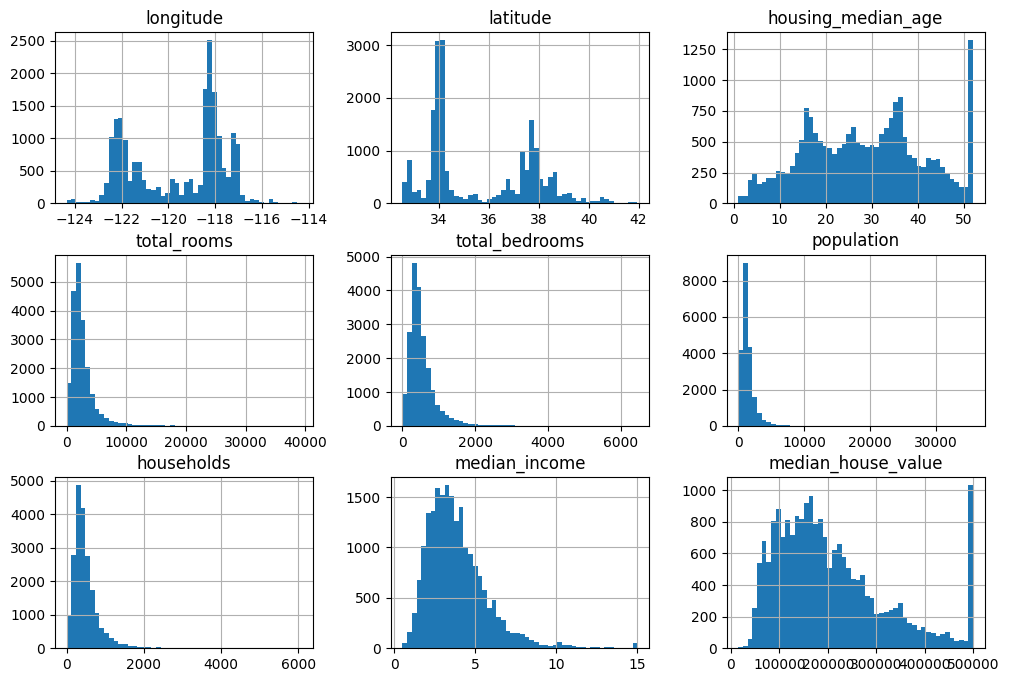

In [6]:
housing.hist(bins=50, figsize=(12,8))
plt.show()

The variables _latitude_ and _longitude_ seem defined appropriately and do not present too many oddities, except for their bimodal distributions.

The variables _housing\_median\_age_ is distributed between 1 and 52, so it's relates to the age of the *house*, not of the inhabitants. Furthermore, the median age is capped at 52, and all centennial house will be given this value instead.

The variables _total\_rooms_, _total\_bedrooms_, _population_, _households_ do not present anything odd, but will require to be transformed in order to be more symmetric.

The variable _median\_income_ is not only skewed right, but is not expressed in US dollar, as well ,as being capped at 0.5 and 15. Each unit represents ~$10'000.

Finally, the variable _median\_house\_value_ is both skewed to the right, as well as being capped of at $500'000, there will need to be transformed for better symmetry.




## Train-Test Split
Before going any further, it's important to split the test data from the test dataset and to not look at the former until we are confident in our model.

### Stratification
According to experts, median income is a extremely important predictor of median housing prices, and therefore we should ensure that the distribution of this variable is similar in our training and testing sets.

In order to allow this, we first need to define a stratification strategy.
**From what I gather**, most stratification methods in sklearn try and reproduce the distribution of a given array/column when generating the train/test sets. As such, as we want to stratify from median income, we need to easily represent the income distribution so that it can be reproduced in test/train sets.
Based on the example from the book, we will do that by categorizing income.

#### Discretization Attempt 1

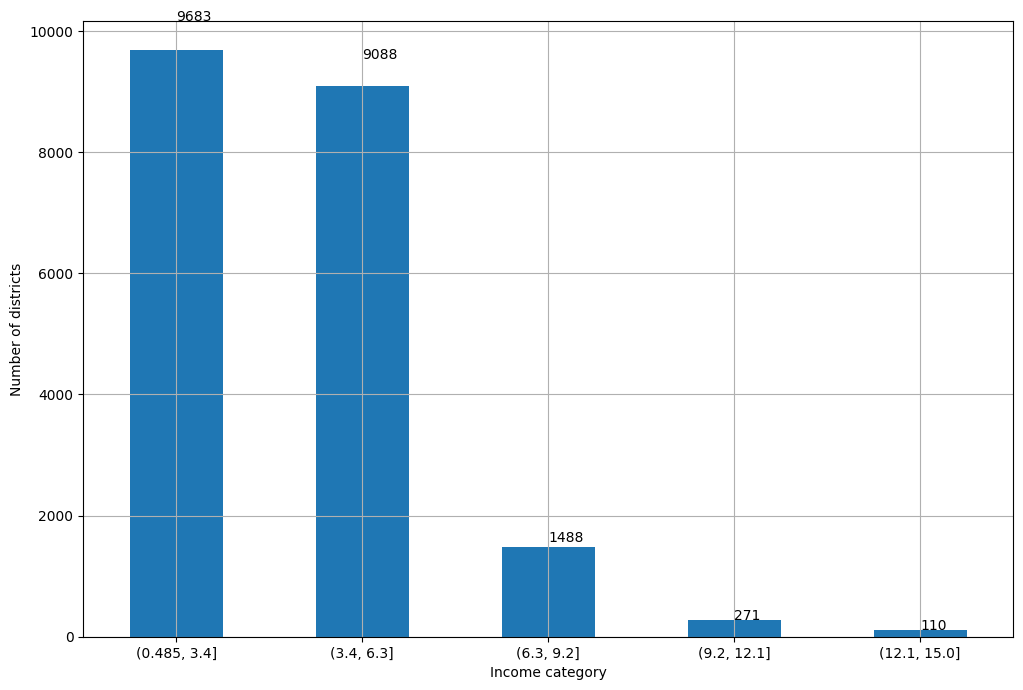

In [7]:
#To avoid copying completely the code, let's try to discretize slightly differently
test_discret1 = pd.cut(housing.median_income, bins=5)

fig = plt.figure(figsize=(12, 8))
# Let's directly represent the distribution of my discretization to see what I got

test_discret1.value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")

for index, value in enumerate(test_discret1.value_counts().sort_index()):
    plt.text(index, value*1.05, value)
    
    
plt.show()

**Ouch**
So much for that.
So, what happened?

So, I asked cut to create 5 bins. It did, those bins are equally distributed along the "median_income" values (hence from max to min), but, and follow me here because it becomes highly technical right here; there's strong income inequality.

Remember, that's partly the reason why we want to stratify according to median income? 

So, what now?

We want to try that again, but this time, we want bins in such a way that the number of elements in each bin roughly follows a normal distribution. __I don't think this last remark is actually true, but...__

In the previous case, we definitely have too few members of the last three stratum to properly train our model on these stratums!

#### Discretization Attempt 2

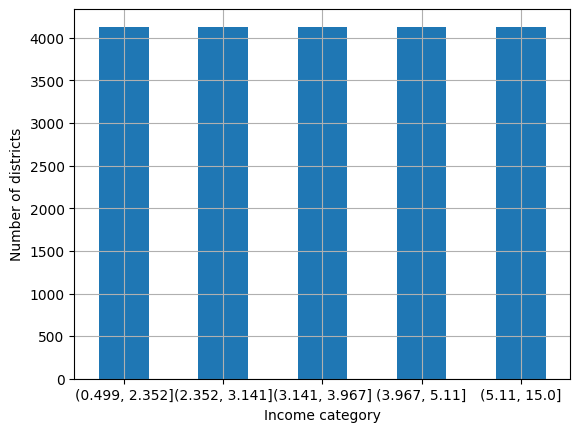

In [8]:
test_discret2 = pd.qcut(housing.median_income, 5)
# Let's directly represent the distribution of my discretization to see what I got
test_discret2.value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

***FUCK***

So no, what I ***actually*** want is not a normal distribution of income!

I need a discretized distribution of income that still somewhat represents the initial distribution of income, without having SO many bins that it becomes useless, all the while each bin should **also** have enough members so that we have enough data in a given bin/stratum to correctly predict the outcome with some precision.

If we were to pick this second stratification attempt, we would actually be doing __disproportionate sampling__ of our population, but given that here we are not interested in the population itself, but in how the income of the population affects the median price of housing, we want to have __proportionate sampling__.

For more info on stratified sampling, see [this link](https://www.scribbr.com/methodology/stratified-sampling/).

The issue with using such distribution is that most categories lose their meaning. There is a lot of granularity in the housing quality/pricing between the most destitute districts and "middle-of-the-road" districts, whereas past a certain points, house become exponentially more expensive in richer districts.
As such, we want a reasonable distribution at the middle range so that we can...

**I think I'm confused now, I should come back to this in the future and try to understand why/if this whole thing is actually relevant**

**After thinking about it longer, this distribution might actually be a good idea. Let's try finishing the whole process and if my outcomes is absolutely terrible, I can point the finger at this step, change this and see if it helps!**

#### Discretization

In [9]:
# housing["income_cat"] = pd.qcut(housing.median_income, 5, labels = [1, 2, 3, 4, 5])
# housing.drop("income_cat", axis=1, inplace=True)
housing_income_cat = pd.qcut(housing.median_income, 5, labels = [1, 2, 3, 4, 5])

#### Train-Test Split

In [10]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing_income_cat, random_state=42)
# strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

## Data Visualization

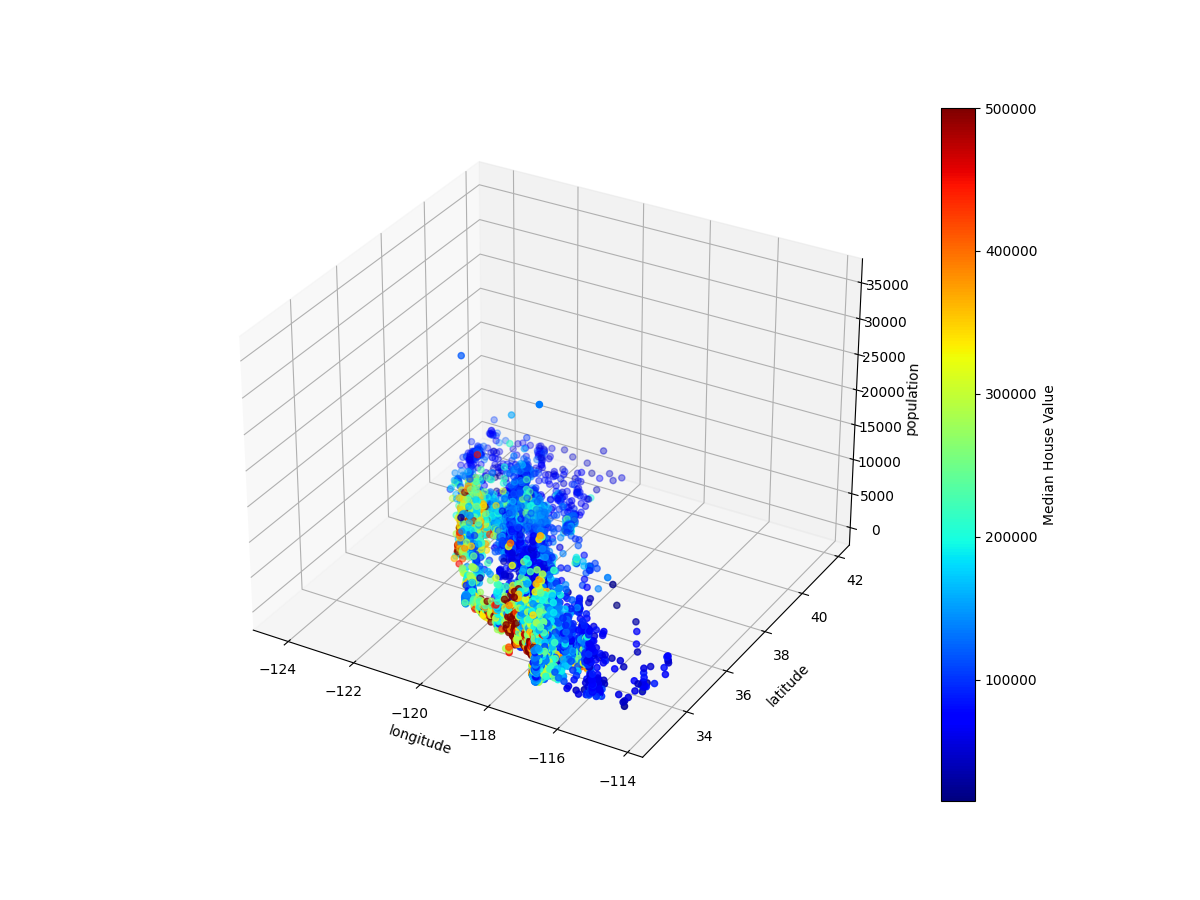

In [11]:
%matplotlib widget
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')

cs = ax.scatter(housing["longitude"], housing["latitude"], housing["population"], c=housing["median_house_value"], cmap="jet")
fig.colorbar(cs, label="Median House Value")

ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_zlabel("population")

plt.show()

In [12]:
time.sleep(5) # Otherwise figures are forked and appear too late

%matplotlib inline
plt.close(fig)
# plt.close(all)

### Correlation

In [13]:
corr_matrix = housing.corr(numeric_only=True)

Since _median\_house\_value_ is our outcome, let's find the factors most correlated with it.

In [14]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

For now, we'll ignore _latitude_ and _longitude_ since they can be difficult for any expert/algorithm to relate their relation with the house value (We need an estimator for lat/long, then we can relate this estimator with our outcome).
This leaves us with the following correlated factors:
- median income
- total rooms
- housing median age

To gain better appreciation of these factors, let's look at them graphically.

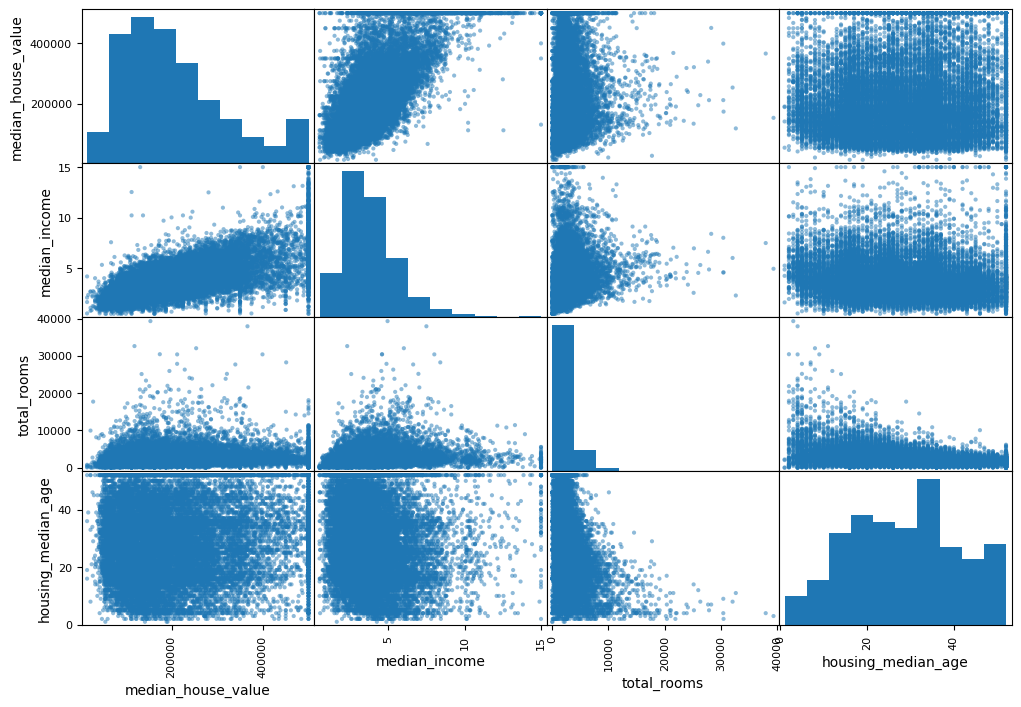

In [15]:
pd.plotting.scatter_matrix(housing[["median_house_value", "median_income","total_rooms", "housing_median_age"]], figsize=(12, 8))
plt.show()

At first glance, the most promising factor (i.e. the one where we can easily see a linear relation between _median\_house\_value_ and the factor) is _median\_income_.

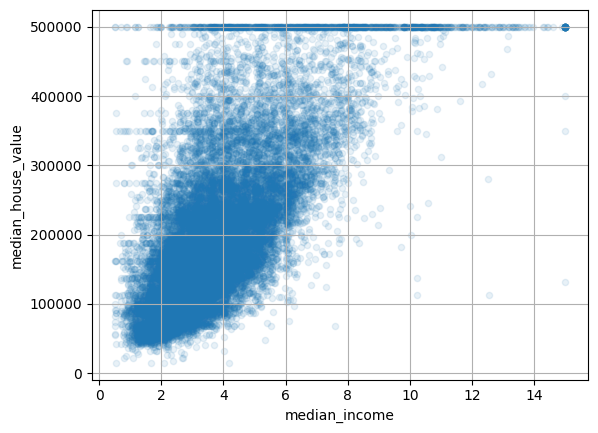

In [16]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
plt.show()

We can clearly see the price cap at \\$ 500'000, but there also appears to be shadow lines at ~\\$450k, ~\\$350k, ~\\$$275k, ~\\$225k, ~\\$190k, ~\\$160k, etc.

If the resulting outcome seems wrong for some value, we might want to retrain our machine after removing the district causing these shadow lines.

## New variables

A certain number of our parameters, while relevant, could probably be improved. For example, while the number of rooms in a district is interesting, knowing the average number of rooms per house might prove more relevant, as more expensive houses would present more rooms than poorer housing, etc.

In [17]:
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["people_per_house"] = housing["population"]/housing["households"]

#### Correlation (With new variables)

In [18]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
rooms_per_house       0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
people_per_house     -0.023737
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bedrooms_ratio       -0.255880
Name: median_house_value, dtype: float64

The new variables _rooms\_per\_house_ and _bedrooms\_ratio_ proved to be quite relevant, showing quite high correlation with _median\_house\_values_!

Let's plot linear correlation again with these new variables!

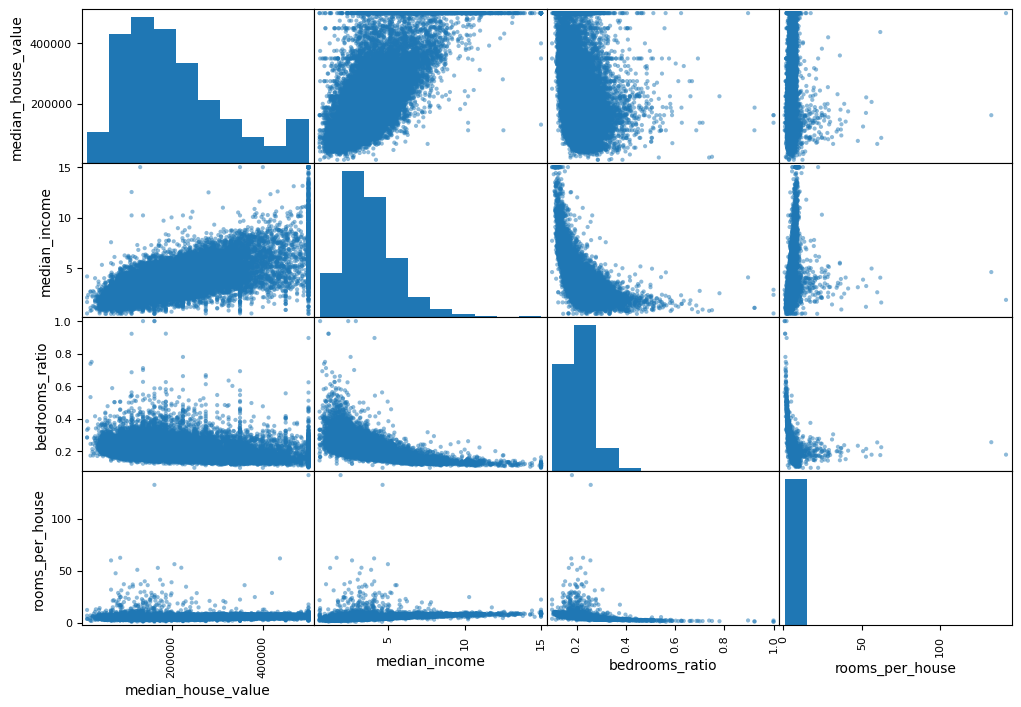

In [19]:
pd.plotting.scatter_matrix(housing[["median_house_value", "median_income","bedrooms_ratio", "rooms_per_house"]], figsize=(12, 8))
plt.show()

Among our new variables, _bedrooms\_ratio_ presents a relation, though obviously non-linear, as can be observed below.

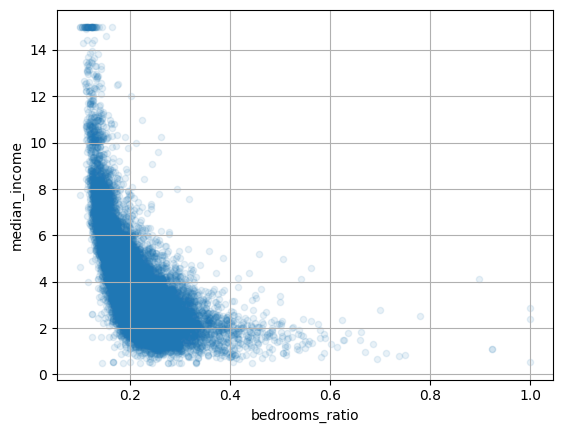

In [20]:
housing.plot(kind="scatter", x="bedrooms_ratio", y="median_income", alpha=0.1, grid=True)
plt.show()

## Data Preparation
Before going into the thick of it, we need to separate predictors and labels.

This way we also keep a backup of our variables if we need to go back to a previous state!

In [21]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Pipelines

### Ratio Pipeline
This is a very simple pipeline/function which encompass all operations necessary to compute ratio operations (such as defining _rooms\_per\__house_ previously)

In [22]:
def column_ratio(X):
    return X[:, [0]]/X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return["ratio"]

ratio_pipeline = Pipeline([    
    ("impute", SimpleImputer(strategy="median")),
    ("computeRatio", FunctionTransformer(column_ratio, feature_names_out=ratio_name)),
    ("standardize", StandardScaler())
])

### Logarithm Pipeline
Features which present long tails to the right, and therefore need to be transformed in order to be more symmetric.

This will be done by replacing these features with their logarithm.

In [23]:
log_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("computeLog", FunctionTransformer(np.log, feature_names_out="one-to-one")), # Don't ask me WHY feature_names_out must be "one-to-one", but it crashes if it's anything else!
    ("standardize", StandardScaler())
])

### Geography Pipeline
As mentioned earlier, contextualizing the latitude and longitude in their current form is difficult for experts and machines, therefore we want to transform them to simplify this.

The book offers a great idea in which we compute clusters/hotspots of house values, then we compute the distance of each geographic coordinates to the nearest cluster!
I am hopeful I would have thought of the base idea, but I am not sure I'd have been able to implement it. But since I'm here to learn, I will shamelessly steal their implementation.

The first step of this pipeline is to compute k-means clusters of the two geographic coordinates we pass in arguments (bunch up together the x and y coordinates and finds the closest clusters).

Then, we use _rbf\_kernel_ to compute the similarity (according to ~all (non-geographic) features (income, age, total\_rooms, etc.))~ the geographic distance between each district (rows in the _housing_ table) and each cluster center.
Therefore, the output of this will be a matrix with the same number of rows as _housing_ and 1 column per cluster center.

In [24]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None, n_init=10):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        self.n_init = 10
        
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state, n_init=self.n_init)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self # Necessary, must always be returned for fit
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [25]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)

### Categorical Pipeline
The variable _ocean\_proximity_ is a categorical, and to allow correct processing by our algorithms, we will transform it into numerical. But to avoid "ordering" them, we will use a binary attribute per category, so that "proximity" in number (0: 'Near Bay', 1: '>2H Ocean', for example) is not interpreted as a proximity in value. To do so, we will use OneHotEncoder.

In [26]:
cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("OneHotEncoder", OneHotEncoder(handle_unknown="ignore")),
])

### Default Numerical Pipeline

In [27]:
default_num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

### Age Pipeline
In the book, no special pipeline was created for the variable _housing\_median\_age_, even though they noted the bimodal distribution of this variable.

Once the base pipeline presented in the book has been copied here, it would be a good idea to flesh out the rbf proximity for the 35 and 15 age groups to see if it improves our model.

First of all, I wonder if I could use K-Means on a single variable? I haven't done it yet, but I also see no reason why I couldn't. So let's try.

In [28]:
age_kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)

# age_test = age_kmeans.fit_predict(housing["housing_median_age"].values.reshape(-1, 1))
age_test = age_kmeans.fit_predict(housing[["housing_median_age"]])

print(pd.DataFrame(age_test).describe())
print(age_kmeans.cluster_centers_)

                  0
count  16512.000000
mean       0.496427
std        0.500002
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
[[39.05039086]
 [17.95425156]]


Perfect! I am quite happy about these results! "My" methodology returned two kernel (duh), and the values look great! I was wondering how to get a good estimate of the values of the peaks of the bimodal distribution, and here we are! Nice.

Let's do a small plot to see our distribution and our new cluster center superimposed on them!

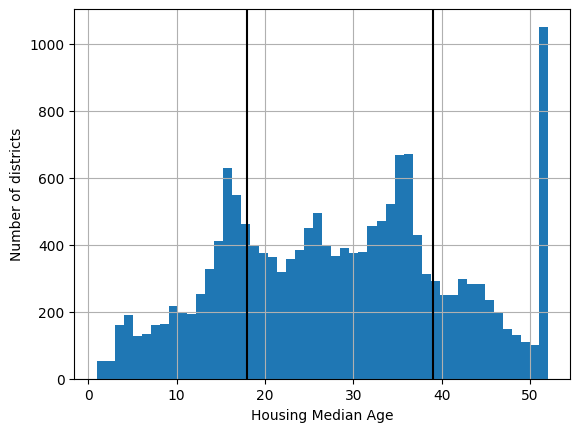

In [29]:
housing["housing_median_age"].hist(bins=50)
plt.xlabel("Housing Median Age")
plt.ylabel("Number of districts")

plt.axvline(x=age_kmeans.cluster_centers_[0], color='black')
plt.axvline(x=age_kmeans.cluster_centers_[1], color='black')

#### Age - K-means Cluster #2
Hmm, I'm not THAT happy with the results, actually, the cluster centers seem to be dragged too much to the right compared to my expectations.
And while it's entirely possible I'm wrong about the whole thing, let's try to remove all 50+ data from the k-means input, and see what I get.

                  0
count  15358.000000
mean       0.509767
std        0.499921
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
[[36.55771019]
 [17.4820539 ]]


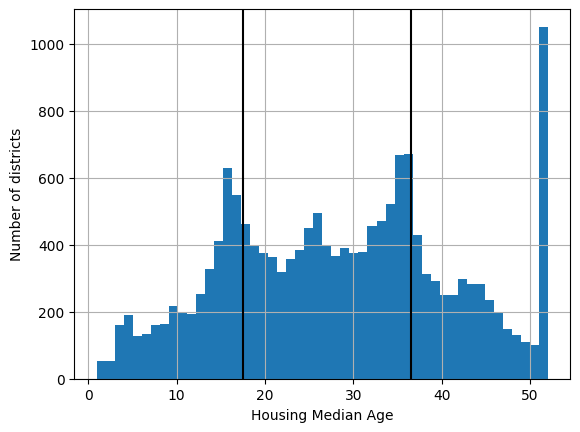

In [30]:
age_kmeans2 = KMeans(n_clusters=2, random_state=42, n_init=10)

housing_age = housing["housing_median_age"].values.copy()
housing_age = housing_age[housing_age<50]
age_test2 = age_kmeans2.fit_predict(housing_age.reshape(-1, 1))
print(pd.DataFrame(age_test2).describe())
print(age_kmeans2.cluster_centers_)

housing["housing_median_age"].hist(bins=50)
plt.xlabel("Housing Median Age")
plt.ylabel("Number of districts")

plt.axvline(x=age_kmeans2.cluster_centers_[0], color='black')
plt.axvline(x=age_kmeans2.cluster_centers_[1], color='black')
plt.show()

Well, we improved the cluster center from 39 to 36, but it would appear I was quite wrong when I said that the 50 cutoff was pulling the data drastically.

#### Age - K-means Cluster #3

But while I'm there, let's just do a last try, this time with three cluster center, maybe we can fit a cluster center around 27? Just curious, I would prefer not using the result of the following k-means clustering.

                  0
count  15358.000000
mean       1.008074
std        0.818846
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        2.000000
[[39.39551799]
 [13.80632411]
 [27.2203032 ]]


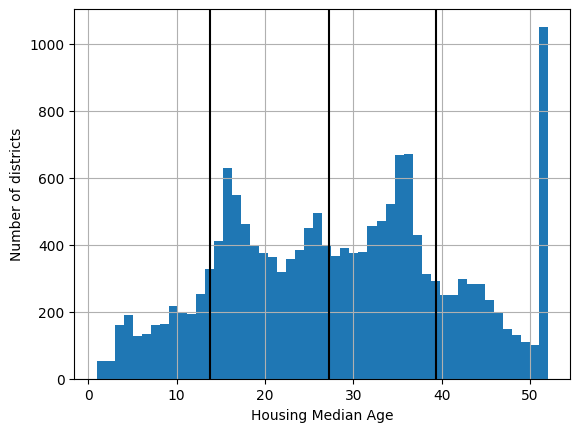

In [31]:
age_kmeans3 = KMeans(n_clusters=3, random_state=42, n_init=10)

age_test3 = age_kmeans3.fit_predict(housing_age.reshape(-1, 1))
print(pd.DataFrame(age_test3).describe())
print(age_kmeans3.cluster_centers_)

housing["housing_median_age"].hist(bins=50)
plt.xlabel("Housing Median Age")
plt.ylabel("Number of districts")

plt.axvline(x=age_kmeans3.cluster_centers_[0], color='black')
plt.axvline(x=age_kmeans3.cluster_centers_[1], color='black')
plt.axvline(x=age_kmeans3.cluster_centers_[2], color='black')
plt.show()

This is a good demonstration that overthinking about something can/will lead to poorer results, we'd stay with our initial K-means clustering with 2 centers and without eliminating the 50+ outliers.

Initially I wanted to check whether it was possible to use k-Means clustering when you have only one variable. And it is.

But reusing K-Means clustering then rbf kernel on the age category, while presumably good, also does not require to delve deeper into ML, whereas the whole idea of the project would be to learn more and see what can be done, tinkering around, and even if I end up using too advanced or poorly advised tools to achieve my goals, as long as I do new stuff, it looks good to me at this stage!

So, after poking around, I have found out about [_PowerTransformer_](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html),  and I see no reason why not use it in place of K-Means + RBF kernel, so might as well try. Though, you know I still would need to settle on an estimator for similarity...

I'll settle for a linear kernel, because why not?

### Age - PowerTransformer + linear_kernel

In [32]:
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics.pairwise import linear_kernel

In [33]:
class AgeSimilarity(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.powertransformer_ = PowerTransformer(method='box-cox')
        # self.powertransformer_.fit(X.values.reshape(-1, 1))
        self.powertransformer_.fit(X)
        return self
    
    def transform(self, X):
        # return linear_kernel(X.values.reshape(-1, 1))
        return linear_kernel(X)

In [34]:
age_simil = AgeSimilarity()
similarities = age_simil.fit_transform(housing[["housing_median_age"]])

Ah, well, that might not be the best idea, look at the size of the output:

In [35]:
similarities.shape

(16512, 16512)

Training anything on such a large matrix for a single feature will probably eat lots of time and power for not much, let's try to find a better kernel.

Also, _PowerTransformer_ might not be the most appropriate choice of transformer.


### Age - K-Means + rbf_kernel

*Let's start again from scratch*.
Let's fit a gaussian distribution around 39 and 17 (these values were obtained previously thanks to k-means clustering), and then somehow, for each point, compute the similarity to each 

In [36]:
age_simil = ClusterSimilarity(n_clusters=2, random_state=42)
similarities = age_simil.fit_transform(housing[["housing_median_age"]])

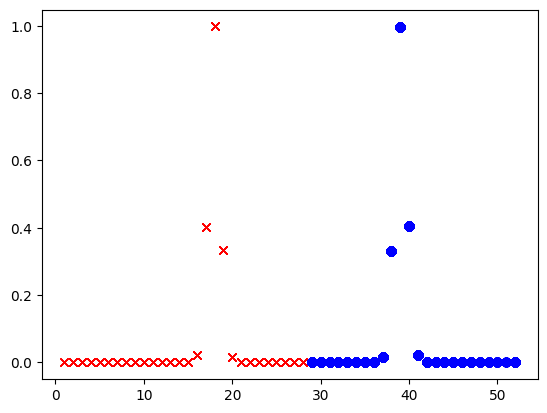

In [37]:
ages = housing["housing_median_age"]
similarity_indexor = similarities[:, 0] > similarities[:, 1]

plt.plot(ages[similarity_indexor], similarities[similarity_indexor, 0], 'bo')
plt.plot(ages[~similarity_indexor], similarities[~similarity_indexor, 1], 'rx')

plt.show()

Looks good! Let's use that in our pipeline!

### Complete Transformer

In [38]:
preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline, ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline, ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline, ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ("age", age_simil, ["housing_median_age"]),
], remainder=default_num_pipeline)

In [39]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 25)

In [40]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'age__Cluster 0 similarity', 'age__Cluster 1 similarity'],
      dtype=object)

## Select and Train a Model

### Linear Regression Model

In [41]:
lin_reg = Pipeline([
    ("preprocesing", preprocessing),
    ("LinReg", LinearRegression())
 ])
lin_reg.fit(housing, housing_labels)

housing_predictions_linearReg = lin_reg.predict(housing)

lin_rmse = mean_squared_error(housing_labels, housing_predictions_linearReg, squared=False)
print('RMSE for Linear Regressor Model: ' + str(lin_rmse.round(2)))

RMSE for Linear Regressor Model: 69109.98


Let's look at the 25% and 75% quantiles of _median\_house\_value_ to contextualize this.

In [42]:
q25, q75 = np.percentile(housing_labels, [25, 75])

print('RMSE for Linear Regressor Model: ', lin_rmse.round(2))
print("25th percentile:", q25, "(Error:", (lin_rmse/q25*100).round(2), '%)')
print("75th percentile:", q75, "(Error:", (lin_rmse/q75*100).round(2), '%)')

RMSE for Linear Regressor Model:  69109.98
25th percentile: 120000.0 (Error: 57.59 %)
75th percentile: 265600.0 (Error: 26.02 %)


The "errors" are just provided for quick comparison and do not have actual meaning.

But the error of our linear model is gigantic. So let's quickly try a random forest regressor, as proposed in the chapter.

### Random Forest Regressor

In [43]:
forest_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("ForestReg", RandomForestRegressor(random_state=42)),
])
forest_reg.fit(housing, housing_labels)
housing_predictions_forestReg = forest_reg.predict(housing)

forest_rmse = mean_squared_error(housing_labels, housing_predictions_forestReg, squared=False)
print('RMSE for Random Forest Regressor: ', forest_rmse.round(2))

RMSE for Random Forest Regressor:  17791.15


![suspicious_Fry_meme](https://i.kym-cdn.com/photos/images/newsfeed/000/131/399/fry.PNG?1307468855)

In [44]:
print('RMSE for Random Forest Regressor:', forest_rmse.round(2))
print("25th percentile:", q25, "(Error:", (forest_rmse/q25*100).round(2), '%)')
print("75th percentile:", q75, "(Error:", (forest_rmse/q75*100).round(2), '%)')

RMSE for Random Forest Regressor: 17791.15
25th percentile: 120000.0 (Error: 14.83 %)
75th percentile: 265600.0 (Error: 6.7 %)


The result seems much better, but it's suspiciously good, and might be due to a random fluke. To check this, let's try cross-validation!

## Cross-Validation

In [45]:
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     69749.086038
std       2557.739561
min      65836.356450
25%      68038.098199
50%      69954.797092
75%      71414.049309
max      73440.581406
dtype: float64

Our previous value is relatively close, confirming the poor quality of the linear regression model to the problem at hand  
_shocker, I know!_

In [46]:
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     47738.170043
std       2007.718680
min      45243.845064
25%      46125.531897
50%      47538.511419
75%      48737.784784
max      51862.794411
dtype: float64

In [47]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47738.170043
std       2007.718680
min      45243.845064
25%      46125.531897
50%      47538.511419
75%      48737.784784
max      51862.794411
dtype: float64

Indeed, turns out our previous result (_forest\_rmse_) was a fluke and the other is significantly higher, though still ~30% smaller than our linear model.

But the fact that the difference between these values indicate that this model is still not a good fit (and per the book, it is caused by overfitting).

## Model Fine-Tuning
Even when a model seems pretty appropriate, it is a good idea to check if it can't be improved by fine-tuning its hyper-parameters.

### Grid Search
The simplest method to test the effect of changing a model hyper-parameters consists simply in testing all combinations of varying values for the hyper-parameters. Just train the model with each possible combinations, which we can do with _GridSearchCV_.

In [48]:
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'ForestReg__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'preprocessing__age__n_clusters': [2, 3],
     'ForestReg__max_features': [6, 8, 10]},
]

grid_search = GridSearchCV(forest_reg, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardize',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('computeRatio',
                                                                                          FunctionTransformer(feature_names_out=<function ratio_name at 0x7f2...
                                                                         ClusterSimilarity(n_clusters=2,
                                                                                           random_state=42),
                                                                         ['housing_median_age'])])),
                                       ('ForestReg',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'ForestReg__max_features': [4, 6, 8],
                          'preprocessing__geo__n_clusters': [5, 8, 10]},
                         {'ForestReg__max_features': [6, 8, 10],
                          'preprocessing__age__n_clusters': [2, 3],
                          'preprocessing__geo__n_clusters': [10, 15]}],
             scoring='neg_root_mean_squared_error')

But this process will be quite slow, as we will train our model 3 times (since _cv=3_ in _GridSearchCV_) for each combination, so for the example above, we have 3x3=9 combinations from:  
{'preprocessing\_\_geo\_\_n\_clusters': [5, 8, 10], 'ForestReg\_\_max\_features': [4, 6, 8]}  
and 2x2x3=12 combinations from:  
{'preprocessing\_\_geo\_\_n\_clusters': [10, 15], 'preprocessing\_\_age\_\_n\_clusters': [2, 3], 'ForestReg\_\_max\_features': [6, 8, 10]}  
Which makes for 3x(12+9)=63 rounds of training...

In [49]:
grid_search.best_params_

{'ForestReg__max_features': 6,
 'preprocessing__age__n_clusters': 2,
 'preprocessing__geo__n_clusters': 15}

You'll notice we probably want to confirm that these hyper-parameters are indeed optimal, as both _ForestReg\_\__max\_features_ and _preprocessing\_\_geo\_\_n\_clusters_ have taken their most extreme value, it would be a good idea to check what happens if we allow greater limits on these value in another run of hyper-parameter optimizations.

If we were interested in using this model with the "optimal" values, we can access the model directly:

In [70]:
gridOpti_ForestReg = grid_search.best_estimator_
gridOpti_ForestReg

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardize',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('computeRatio',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f24e5411bd0>,
                                                                                       func=<function col...
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OneHotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f24e262f0a0>),
                                                 ('age',
                                                  ClusterSimilarity(n_clusters=2,
                                                                    random_state=42),
                                                  ['housing_median_age'])])),
                ('ForestReg',
                 RandomForestRegressor(max_features=6, random_state=42))])

Which we could then test with the following command:

In [71]:
gridOpti_ForestReg_predictions = gridOpti_ForestReg.predict(housing)
gridOpti_ForestReg_rmse = mean_squared_error(housing_labels, gridOpti_ForestReg_predictions, squared=False)
print('RMSE for optimized Random Forest Regressor: ', gridOpti_ForestReg_rmse.round(2))

RMSE for optimized Random Forest Regressor:  16220.54


### Randomized Search
As we saw with the previous example, _GridSearchCV_ is not a scalable options for optimizing hyper-parameters. For this, we will make use of *RandomizedSearchCV*.

In [72]:
params_distrib = {'preprocessing__geo__n_clusters': stats.randint(low=3, high=50),
     'ForestReg__max_features': stats.randint(low=2, high=20)}

rand_search = RandomizedSearchCV(forest_reg, param_distributions=params_distrib, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=117)
rand_search.fskleait(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardize',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('computeRatio',
                                                                                                FunctionTransformer(feature_names_out=<function ratio_name a...
                                                                               ['housing_median_age'])])),
                                             ('ForestReg',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'ForestReg__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f24e2bd8a00>,
                                        'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f24e042d6f0>},
                   random_state=117, scoring='neg_root_mean_squared_error')

In [73]:
rand_search.best_params_

{'ForestReg__max_features': 4, 'preprocessing__geo__n_clusters': 29}

In [74]:
rand_ForestReg = rand_search.best_estimator_
rand_ForestReg

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardize',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('computeRatio',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f24e5411bd0>,
                                                                                       func=<function col...
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OneHotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f24e04f4fa0>),
                                                 ('age',
                                                  ClusterSimilarity(n_clusters=2,
                                                                    random_state=42),
                                                  ['housing_median_age'])])),
                ('ForestReg',
                 RandomForestRegressor(max_features=4, random_state=42))])

Let's compare the results of this randomized search with those of the previous predictor:

In [75]:
rand_ForestReg_predictions = rand_ForestReg.predict(housing)
rand_ForestReg_rmse = mean_squared_error(housing_labels, rand_ForestReg_predictions, squared=False)
print('RMSE for optimized Random Forest Regressor: ', gridOpti_ForestReg_rmse.round(2))
print('RMSE for randomized Forest Regressor: ', rand_ForestReg_rmse.round(2))

RMSE for optimized Random Forest Regressor:  16220.54
RMSE for randomized Forest Regressor:  16174.34


As we can see, the results for the randomized version are ever so slightly better.

(If we come back to this project, let's add a comparison based on training time too.)

### Analyzing the best models and their errors
Inspecting the resulting models will give us an insight into the relative importance of each attribute when generating the predictions:

In [112]:
final_model = rand_ForestReg
final_featuresImportance = final_model["ForestReg"].feature_importances_
# [str(x.round(2)*100) + '%'for x in final_featuresImportance] #Useless here, since we are going to sort on the values, and that's not possible if we turn our floats into strings :p
sorted(zip(final_featuresImportance, final_model["preprocessing"].get_feature_names_out()), reverse=True)

[(0.13758447969201276, 'log__median_income'),
 (0.06362425700328485, 'rooms_per_house__ratio'),
 (0.062113571376021845, 'cat__ocean_proximity_INLAND'),
 (0.06061210653215922, 'bedrooms__ratio'),
 (0.04697107299145419, 'people_per_house__ratio'),
 (0.04644721780549303, 'geo__Cluster 15 similarity'),
 (0.03608348768357887, 'geo__Cluster 3 similarity'),
 (0.03211445725191155, 'geo__Cluster 2 similarity'),
 (0.030279065339557987, 'geo__Cluster 8 similarity'),
 (0.028917127223013338, 'geo__Cluster 13 similarity'),
 (0.027644254849414022, 'geo__Cluster 27 similarity'),
 (0.02227458757461301, 'geo__Cluster 28 similarity'),
 (0.021840881856364958, 'geo__Cluster 21 similarity'),
 (0.021359360802026477, 'geo__Cluster 22 similarity'),
 (0.021069789112641485, 'geo__Cluster 25 similarity'),
 (0.020670228400098595, 'geo__Cluster 26 similarity'),
 (0.02016418531582129, 'geo__Cluster 17 similarity'),
 (0.020025893268308212, 'geo__Cluster 7 similarity'),
 (0.01925129514174533, 'geo__Cluster 14 similari

Based on this, we can see that only cat__ocean_proximity_INLAND has a relative importance above 1%, so we might want to transform this categorical boolean where INLAND=True and False for all other categories, removing some less useful features.

### Evaluate the predictor on the test set

In [126]:
test_housing = strat_test_set.drop("median_house_value", axis=1)
test_housing_labels = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(test_housing)

final_rmse = mean_squared_error(test_housing_labels, final_predictions, squared=False)
print('RMSE for final model, on test data: ', final_rmse.round(2))
print('_'*25, '\nProvided for comparison:')
print('RMSE for optimized Random Forest Regressor, on training data: ', gridOpti_ForestReg_rmse.round(2))
print('RMSE for randomized Forest Regressor, on training data: ', rand_ForestReg_rmse.round(2))

RMSE for final model, on test data:  40513.43
_________________________ 
Provided for comparison:
RMSE for optimized Random Forest Regressor, on training data:  16220.54
RMSE for randomized Forest Regressor, on training data:  16174.34


So, turns out that even though the fine-tuning granted me much lower RMSE on the training data, this did not translate to significantly improved results when predicting the test data, and I've even remained in the range from the book.

For completeness' sake, lets' compute the 95CI of our estimate:

In [146]:
squared_errors = (final_predictions - test_housing_labels)**2
CI95 = np.sqrt(stats.t.interval(0.95, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))
print('95% CI for the RMSE of the final model, on test data: ', CI95.round(2))

95% CI for the RMSE of the final model, on test data:  [38395.63 42525.9 ]


#### Confidence Interval Explanations
I have trust issues, as well as not perfectly understanding what's going on in interval, so I'll redo the parts I don't understand here:

First, let's just compute the degree of freedom:
```
int_df = len(squared_errors)-1
``` 
We apply -1 due to the definition of RMSE.        
<br/><br/>

Then, let's compute the average of the squared errors.
```
float_SEM = squared_errors.mean() 
```
In the following operation, it simply informs *stats.t.interval* of the position of the interval itself!
Technically, you can obtain the exact same value with the following code:
```
float_SEM_bis = mean_squared_error(final_predictions, test_housing_labels)
```
<br/><br/>

Now we should compute the scale of the interval we want to build, i.e. the standard error in the computation of the CI.
Therefore, in our current case, this is simply the standard error of the values we are computing the interval for (I mean, that's in all cases, but poor prose and grammar has never stopped me before):
```
float_scale = stats.sem(squared_errors)
```
But I know that when you are confused like that, it's best to spell out ALL the steps, so here you go:
```
float_scale_bis = np.std(squared_errors)/np.sqrt(len(squared_errors)-1)
```
I'm drawing the line at reimplementing the standard deviation.
<br/><br/>

Okay! Now we have all the tools to make our computation :)
We plug in 0.95, since we want the <strong>95</strong>CI:
```
stats.t.interval(0.95, int_df, loc=float_SEM, scale=float_scale)
```
Though,technically that's the MSE, so we still need to take the square root of this to obtain the RMSE, but I left that one out.
So, yeah, the confusion came simply from the fact that I thought this stats.t.interval was doing some fancy stuff, when it's actually just computing intervals based on parameters (as the name implies...).

In [187]:
## Attempt 1
# squared_errors_bis = (squared_errors - squared_errors.mean())/stats.sem(squared_errors)
# CI95_bis = np.sqrt(stats.t.interval(0.95, len(squared_errors_bis)-1))
# CI95_bis

## Attempt 2
# float_scale = stats.sem(squared_errors)
# int_df = len(squared_errors)-1
# float_shiftScale_squared_errors = (0.95-squared_errors.mean())/float_scale #TG. Obviously there's an issue here since I'm substracting the mean to 0.95
# CI95_bis = np.sqrt(stats.t.interval(float_shiftScale_squared_errors, int_df)/float_scale)

## Attempt 3
# Oh lol, okay I understand where my confusion comes from!
# int_df = len(squared_errors)-1 #We apply -1 due to the definition of RMSE, but this is just the degree of freedom
# float_SEM = squared_errors.mean() # This is just the average of the squared error. In the following operation, it simply informs stats.t.interval of the position

## Production Tweaks
Enabling tools to simplify launch, update and maintenance of tools is much easier if done from the get go, let's see the most common options presented in the book.
For started, saving the final model is straight forward:

In [211]:
# Let's just cerate a small variable to timestamp correctly our model, to avoid crushing previous one and have better traceability
finalModel_timestamp = datetime.now().strftime('%Y%m%dT%H%M%S')

with open(finalModel_timestamp + "_final_model.pkl", 'wb') as file:
    joblib.dump(final_model, file)

If we save the model, we should also save the training and test data, so that we are certain we can get them in the exact same shape/form it was during today's session:

In [212]:
import pickle
with open(finalModel_timestamp+"_housing.pkl", 'wb') as file:
    pickle.dump(housing, file)

with open(finalModel_timestamp+"_housing_labels.pkl", 'wb') as file:
    pickle.dump(housing_labels, file)

with open(finalModel_timestamp+"_test_housing.pkl", 'wb') as file:
    pickle.dump(test_housing, file)

with open(finalModel_timestamp+"_test_housing_labels.pkl", 'wb') as file:
    pickle.dump(test_housing_labels, file)


We can then reload the files:

In [215]:
with open(finalModel_timestamp+"_test_housing_labels.pkl", 'rb') as file:
    # Call load method to deserialze
    test_housing_labels_reloaded = pickle.load(file)
print(test_housing_labels_reloaded)

14814    285400.0
18689    151300.0
14930    344000.0
5244     158200.0
13323    228100.0
           ...   
20239    300000.0
13623    277500.0
19426    295600.0
1519     115000.0
198       99100.0
Name: median_house_value, Length: 4128, dtype: float64
